## Final Project Submission

Please fill out:
* Student name: 
* Student pace: self paced / part time / full time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
from statsmodels.api import OLS, add_constant
import seaborn as sns

%matplotlib inline

df_original = pd.read_csv('data/kc_house_data_reload.csv')

In [2]:
#Copy the original dataframe to maintain an untouched copy
df_edition_1 = df_original.copy()

#Change the '[sqft_basement]' from object to float data type & check for null values
df_edition_1['sqft_basement'] = pd.to_numeric(df_edition_1['sqft_basement'], errors='coerce')
df_edition_1['sqft_basement'].isna().sum()

454

In [3]:
#Drop the null values
df_edition_1.dropna(subset=['sqft_basement'], inplace=True)

#Drop any unwanted columns
df_edition_2 = df_edition_1.drop(['date', 'id', 'view', 'waterfront', 'lat', 'long', 'view', 'yr_renovated'], axis=1);

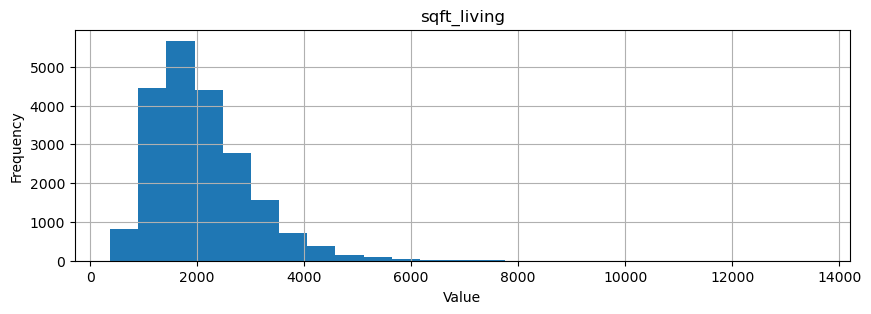

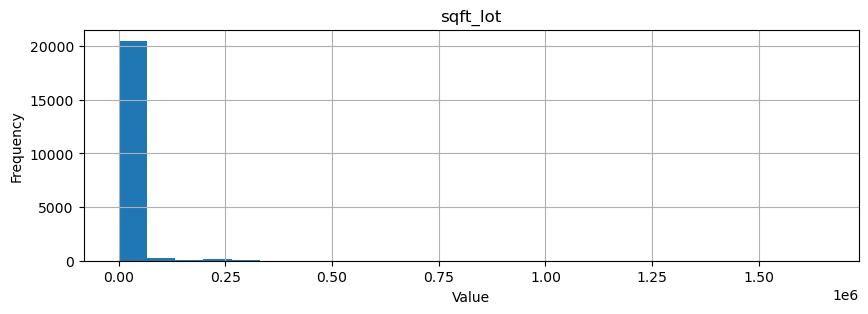

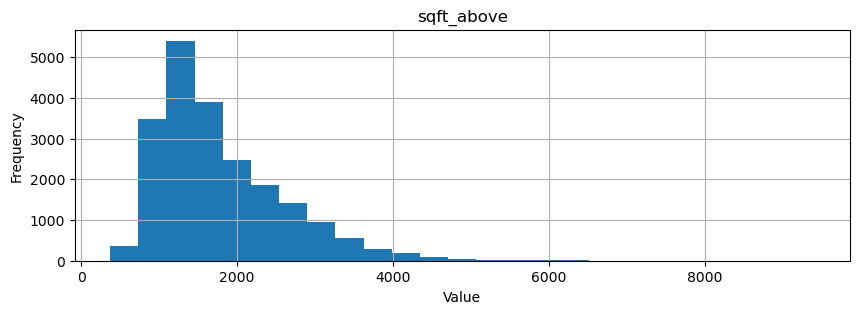

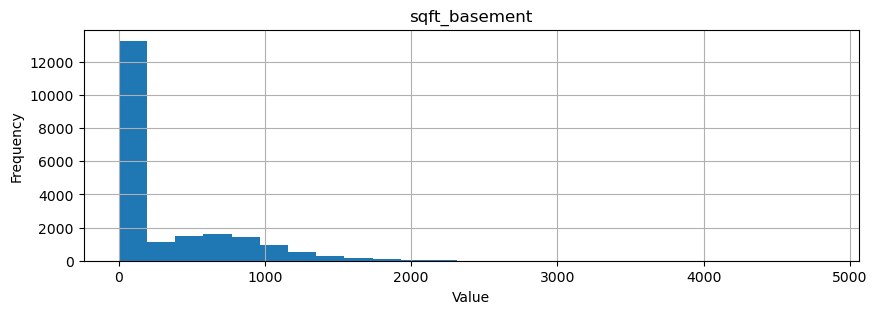

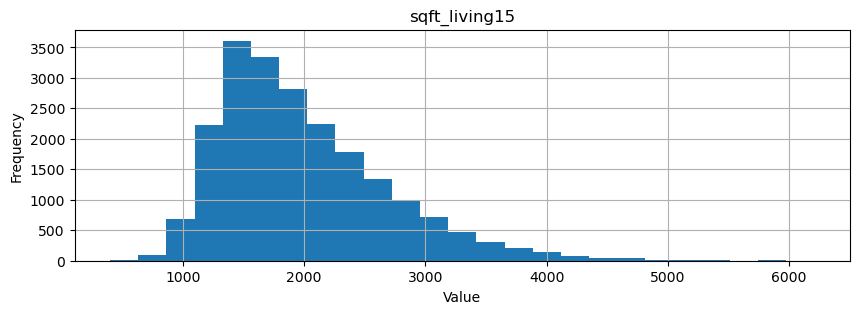

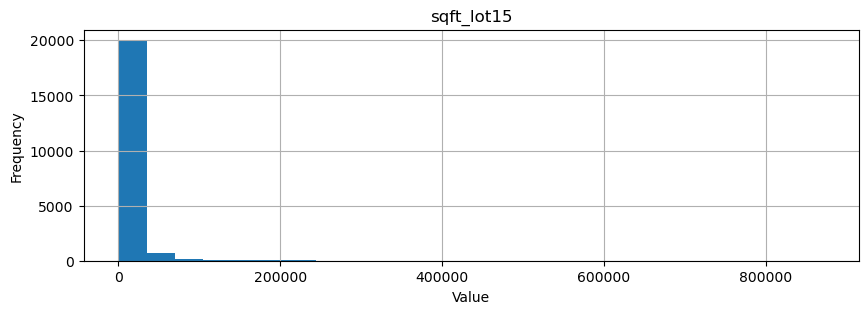

In [4]:
#Create a variable for the predictor variable 'price'
pred_var = ['price']
#Create a variables for the continuous and categorical varibales (without the predictor 'price')
continuous_var = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement','sqft_living15', 'sqft_lot15']
categorical_var = ['bedrooms', 'bathrooms', 'floors', 'condition', 'grade', 'zipcode','yr_built']

#Use histograms for the numeric variables to visulaize the distritubion
for col in df_edition_2[continuous_var]:
    plt.figure(figsize=(10, 3))
    df_edition_2[col].plot(kind='hist', bins=25)
    plt.title(f'{col}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

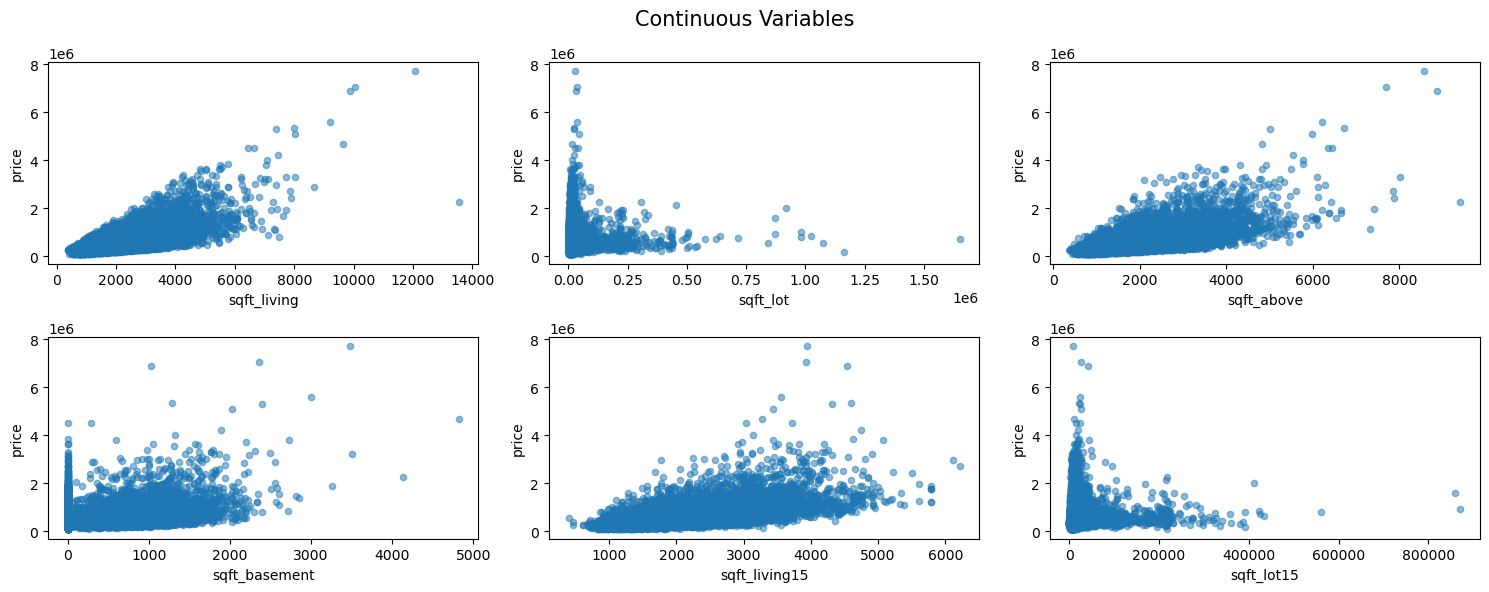

In [5]:
#Use scatter plots for the continuous variables to show any linear / non linear relationships
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 6))

for xcol, ax in zip(continuous_var, axes.flatten()):
    if not continuous_var:
        break
    df_edition_2.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.5)

fig.suptitle("Continuous Variables", fontsize=15)

plt.tight_layout()
plt.show()

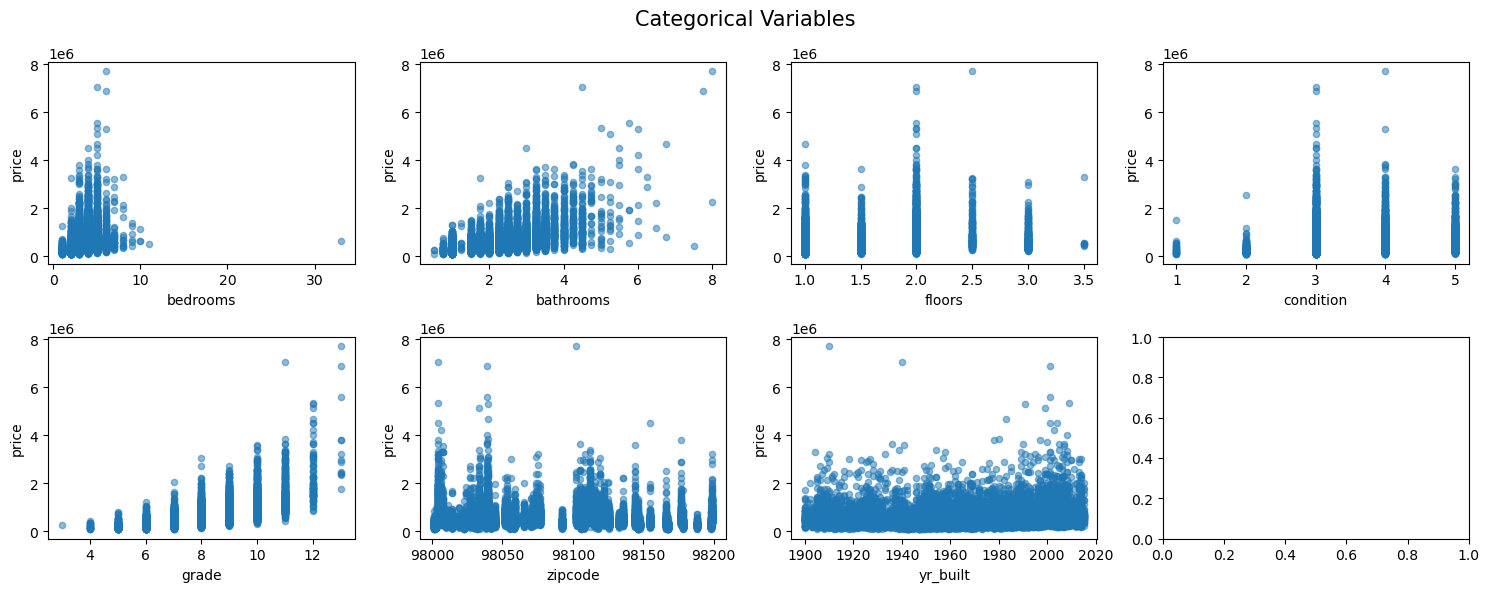

In [6]:
#Use histograms for the categorical variables to show any linear / non linear relationships
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 6))

for xcol, ax in zip(categorical_var, axes.flatten()):
    if not categorical_var:
        break
    df_edition_2.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.5)

fig.suptitle("Categorical Variables", fontsize=15)

plt.tight_layout()
plt.show()

In [7]:
#Remove the outliers with a lambda function
z_scores = df_edition_2.apply(lambda x: (x - x.mean()) / x.std())
threshold = 4
df_edition_3 = df_edition_2[(z_scores.abs() < threshold).all(axis=1)]

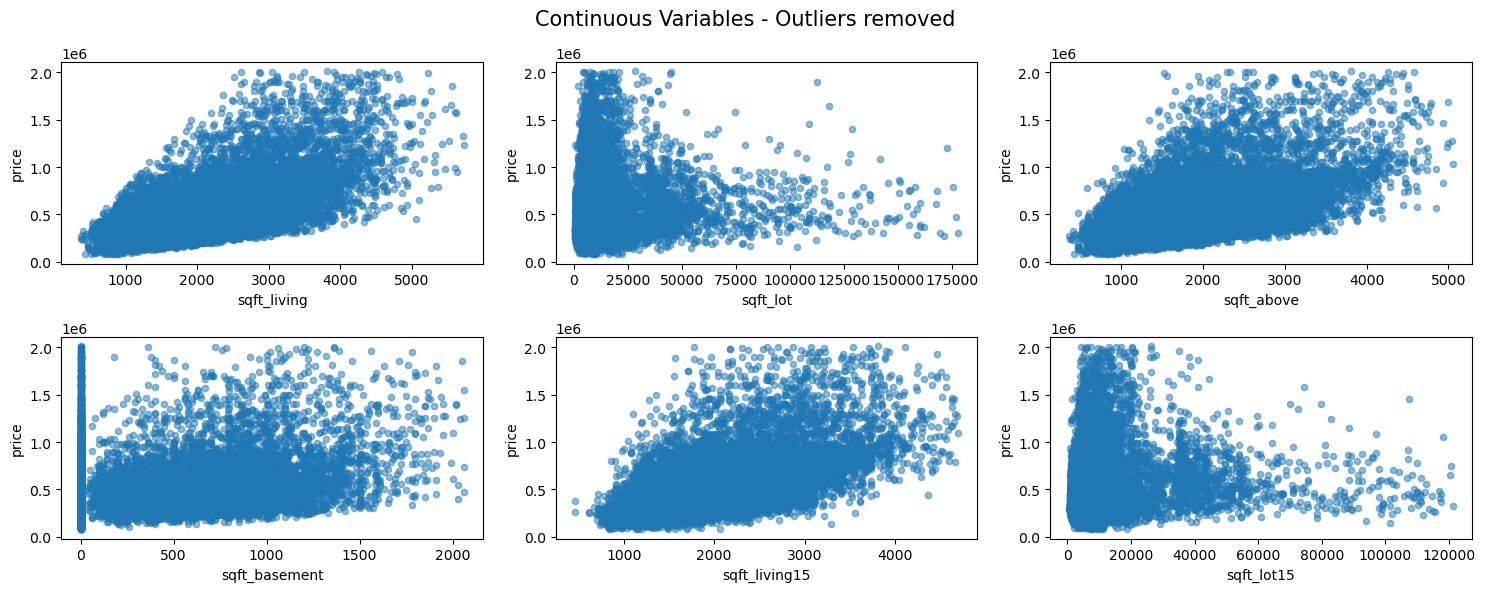

In [8]:
#check the distribution of the continuous variables without the outliers
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 6))

for xcol, ax in zip(continuous_var, axes.flatten()):
    if not continuous_var:
        break
    df_edition_3.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.5)

fig.suptitle("Continuous Variables - Outliers removed", fontsize=15)

plt.tight_layout()
plt.show()

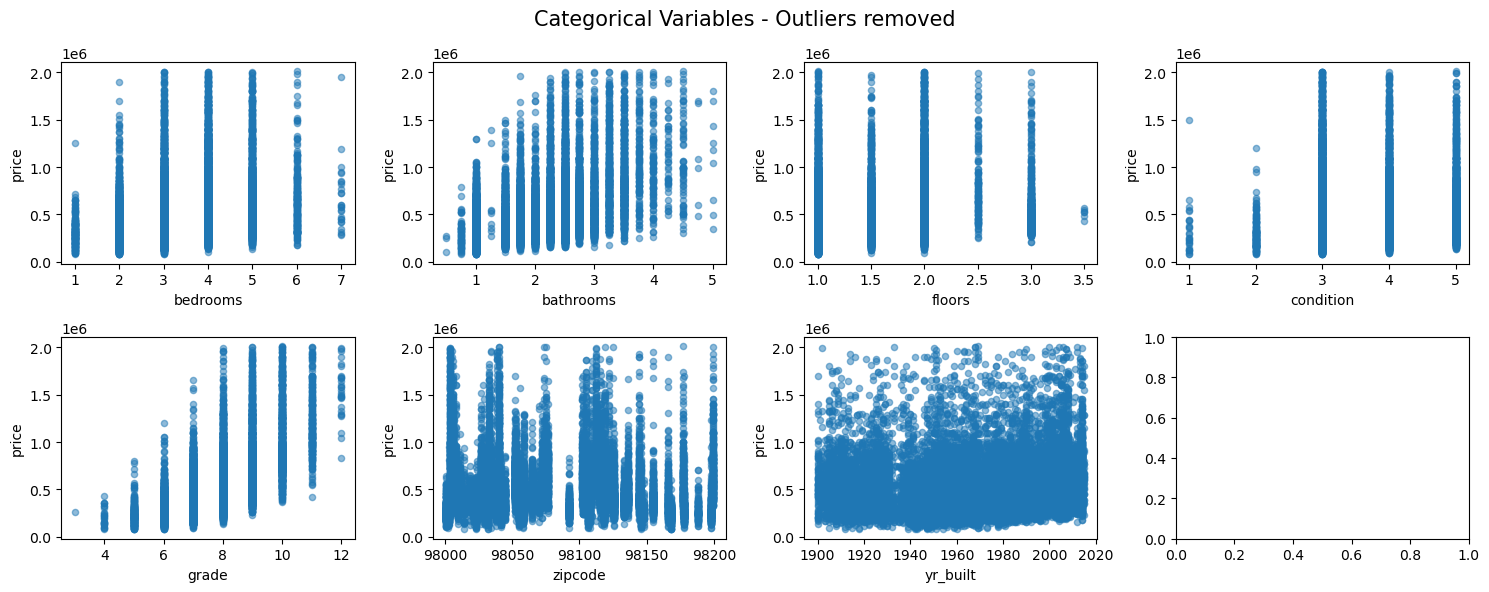

In [14]:
#check the distribution of the categorical variables without the outliers
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 6))

for xcol, ax in zip(categorical_var, axes.flatten()):
    if not categorical_var:
        break
    df_edition_3.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.5)

fig.suptitle("Categorical Variables - Outliers removed", fontsize=15)

plt.tight_layout()
plt.show()

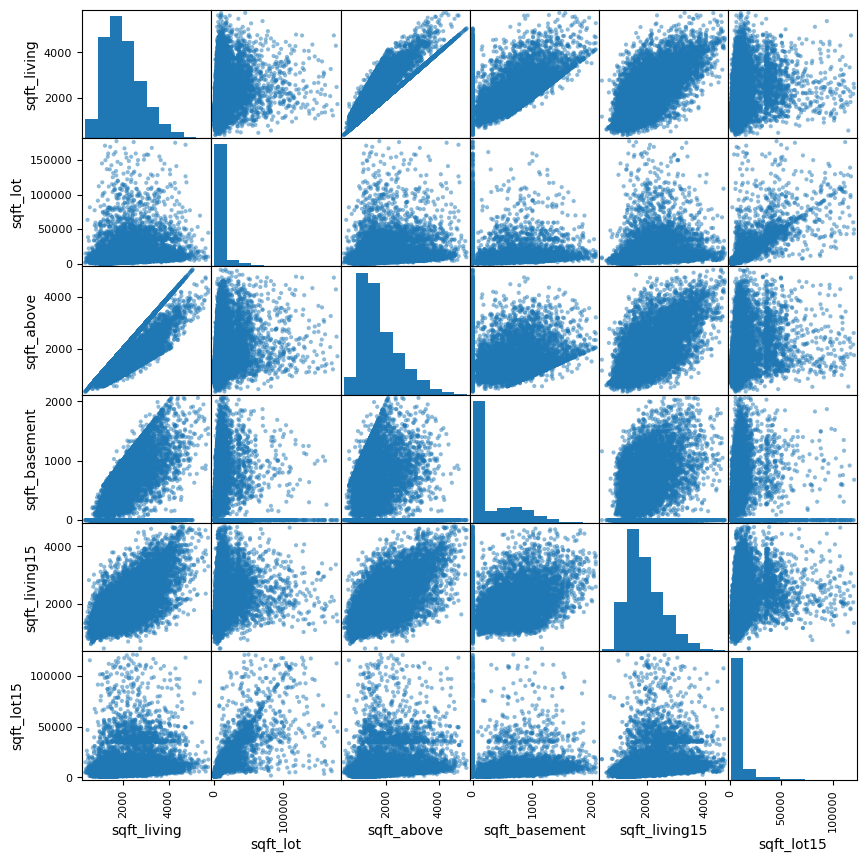

In [15]:
#Checking for High Multicolinearity between the continuous / numerical variables
pd.plotting.scatter_matrix(df_edition_3[continuous_var],figsize  = [10, 10]);
plt.show()

In [16]:
#Show the high multicolinearity pairs
numeric_pairs = df_edition_3[continuous_var].corr().abs().stack().reset_index().sort_values(0, ascending=False)
numeric_pairs['pairs'] = list(zip(numeric_pairs.level_0, numeric_pairs.level_1))
numeric_pairs.set_index(['pairs'], inplace=True)
numeric_pairs.drop(columns=['level_1', 'level_0'], inplace=True)
numeric_pairs.columns = ['cc']
numeric_pairs.drop_duplicates(inplace=True)

numeric_pairs[(numeric_pairs.cc > 0.75) & (numeric_pairs.cc < 1)]

,cc
pairs,
"(sqft_living, sqft_above)",0.859728
"(sqft_lot15, sqft_lot)",0.787175
"(sqft_living15, sqft_living)",0.753949


The description for each column with high multicolinearity can be seen below:
* __sqft_living:__ footage of the home
* __sqft_above:__ square footage of house apart from basement
* __sqft_living15:__ The square footage of interior housing living space for the nearest 15 neighbors
* __sqft_lot15:__ The square footage of the land lots of the nearest 15 neighbors
* __sqft_lot:__ footage of the lot

I think that removing the following columns would make the most sense based on their descriptions and potential impact on the data:
* __sqft_above__
* __sqft_lot15__
* __sqft_living15__

In [17]:
#Drop one column from each pair
df_edition_4 = df_edition_3.drop(['sqft_above', 'sqft_lot15', 'sqft_living15'], axis=1)

### Creating Dummy Variables

In [18]:
#Create dummy variables for each of the categorical variables
bedroom_dummies = pd.get_dummies(df_edition_4['bedrooms'], prefix='beds', drop_first=True).astype(int)
bathrooms_dummies = pd.get_dummies(df_edition_4['bathrooms'], prefix='bath', drop_first=True).astype(int)
floors_dummies = pd.get_dummies(df_edition_4['floors'], prefix='floors', drop_first=True).astype(int)
condition_dummies = pd.get_dummies(df_edition_4['condition'], prefix='cond', drop_first=True).astype(int)
grade_dummies = pd.get_dummies(df_edition_4['grade'], prefix='grade', drop_first=True).astype(int)
zipcode_dummies = pd.get_dummies(df_edition_4['zipcode'], prefix='zip', drop_first=True).astype(int)
yr_built_dummies = pd.get_dummies(df_edition_4['yr_built'], prefix='zip', drop_first=True).astype(int)

#Concat all the dummy varible columns into a single variable
dummy_columns = pd.concat(
    [bedroom_dummies, bathrooms_dummies, floors_dummies, condition_dummies, grade_dummies, zipcode_dummies], axis=1)

#Drop the original columns we used to create dummy variables
df_edition_5 = df_edition_4.drop(['bedrooms','bathrooms','floors','condition','grade','zipcode','yr_built'], axis=1)

#Merge the dummy variables with the remaining numeric columns
df_edition_6 = pd.concat([df_edition_5, dummy_columns], axis=1)

In [19]:
#Create a variable for all the predictor columns
predictor_cols = df_edition_6.drop(['price'], axis=1)

#Fit the model - First iteration
outcome = 'price'
x_cols = predictor_cols.columns
X = df_edition_6[x_cols]
X = add_constant(X)
Y = df_edition_6[outcome]
model = OLS(Y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     777.7
Date:                Mon, 22 Apr 2024   Prob (F-statistic):               0.00
Time:                        20:50:07   Log-Likelihood:            -2.6827e+05
No. Observations:               20444   AIC:                         5.368e+05
Df Residuals:                   20329   BIC:                         5.377e+05
Df Model:                         114                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1.768e+04   1.43e+05     -0.123      0.902   -2.99e+05    2.63e+05
sqft_living     146.3637      2.489     58.816      0.000     141.486     151.241
sqft_lot          0.7040      0.070     10.067      0.000       0.567       0.841
sqft_basement   -26.5866      3.067     -8.668      0.000     -32.598     -20.575
beds_2        -4547.9464   9627.776     -0.472      0.637   -2.34e+04    1.43e+04
beds_3        -2197.8749   9660.244     -0.228      0.820   -2.11e+04    1.67e+04
beds_4        -1.512e+04   9879.983     -1.530      0.126   -3.45e+04    4248.606
beds_5        -3.139e+04   1.04e+04     -3.011      0.003   -5.18e+04    -1.1e+04
beds_6        -4.457e+04   1.29e+04     -3.457      0.001   -6.98e+04   -1.93e+04
beds_7        -1.171e+05    2.6e+04     -4.501      0.000   -1.68e+05   -6.61e+04
bath_0.75      7.636e+04   7.18e+04      1.063      0.288   -6.44e+04    2.17e+05
bath_1.0        5.99e+04   7.02e+04      0.853      0.394   -7.78e+04    1.98e+05
bath_1.25      8.879e+04   8.11e+04      1.095      0.274   -7.01e+04    2.48e+05
bath_1.5       5.255e+04   7.03e+04      0.747      0.455   -8.53e+04     1.9e+05
bath_1.75       5.61e+04   7.03e+04      0.798      0.425   -8.17e+04    1.94e+05
bath_2.0       5.553e+04   7.03e+04      0.789      0.430   -8.23e+04    1.93e+05
bath_2.25      7.059e+04   7.04e+04      1.003      0.316   -6.73e+04    2.09e+05
bath_2.5       6.533e+04   7.04e+04      0.929      0.353   -7.26e+04    2.03e+05
bath_2.75      7.894e+04   7.04e+04      1.121      0.262   -5.91e+04    2.17e+05
bath_3.0       7.942e+04   7.05e+04      1.127      0.260   -5.87e+04    2.18e+05
bath_3.25      1.233e+05   7.06e+04      1.747      0.081    -1.5e+04    2.62e+05
bath_3.5        9.77e+04   7.06e+04      1.385      0.166   -4.06e+04    2.36e+05
bath_3.75      1.902e+05   7.13e+04      2.669      0.008    5.05e+04     3.3e+05
bath_4.0        1.36e+05   7.15e+04      1.902      0.057   -4118.986    2.76e+05
bath_4.25      1.262e+05   7.28e+04      1.733      0.083   -1.65e+04    2.69e+05
bath_4.5       1.446e+05   7.21e+04      2.006      0.045    3330.899    2.86e+05
bath_4.75      1.144e+05   8.63e+04      1.327      0.185   -5.46e+04    2.84e+05
bath_5.0       1.603e+05   8.14e+04      1.970      0.049     834.470     3.2e+05
floors_1.5     6602.9164   3410.679      1.936      0.053     -82.290    1.33e+04
floors_2.0    -2.385e+04   3014.314     -7.913      0.000   -2.98e+04   -1.79e+04
floors_2.5    -6191.3211   1.12e+04     -0.552      0.581   -2.82e+04    1.58e+04
floors_3.0    -7.127e+04   6130.005    -11.627      0.000   -8.33e+04   -5.93e+04
floors_3.5    -9.458e+04   4.98e+04     -1.900      0.058   -1.92e+05    3011.781
cond_2         1.992e+04   2.55e+04      0.783      0.434      -3e+04    6.98e+04
cond_3         4.417e+04   2.37e+04      1.867   

### Log transform and normalize

In [20]:
#Copy the df to maintain versions
df_edition_7 = df_edition_6.copy()

In [48]:
#Create a new list of the remaining continuous variables
continuous_var_2 = ['sqft_living', 'sqft_lot', 'sqft_basement','price']

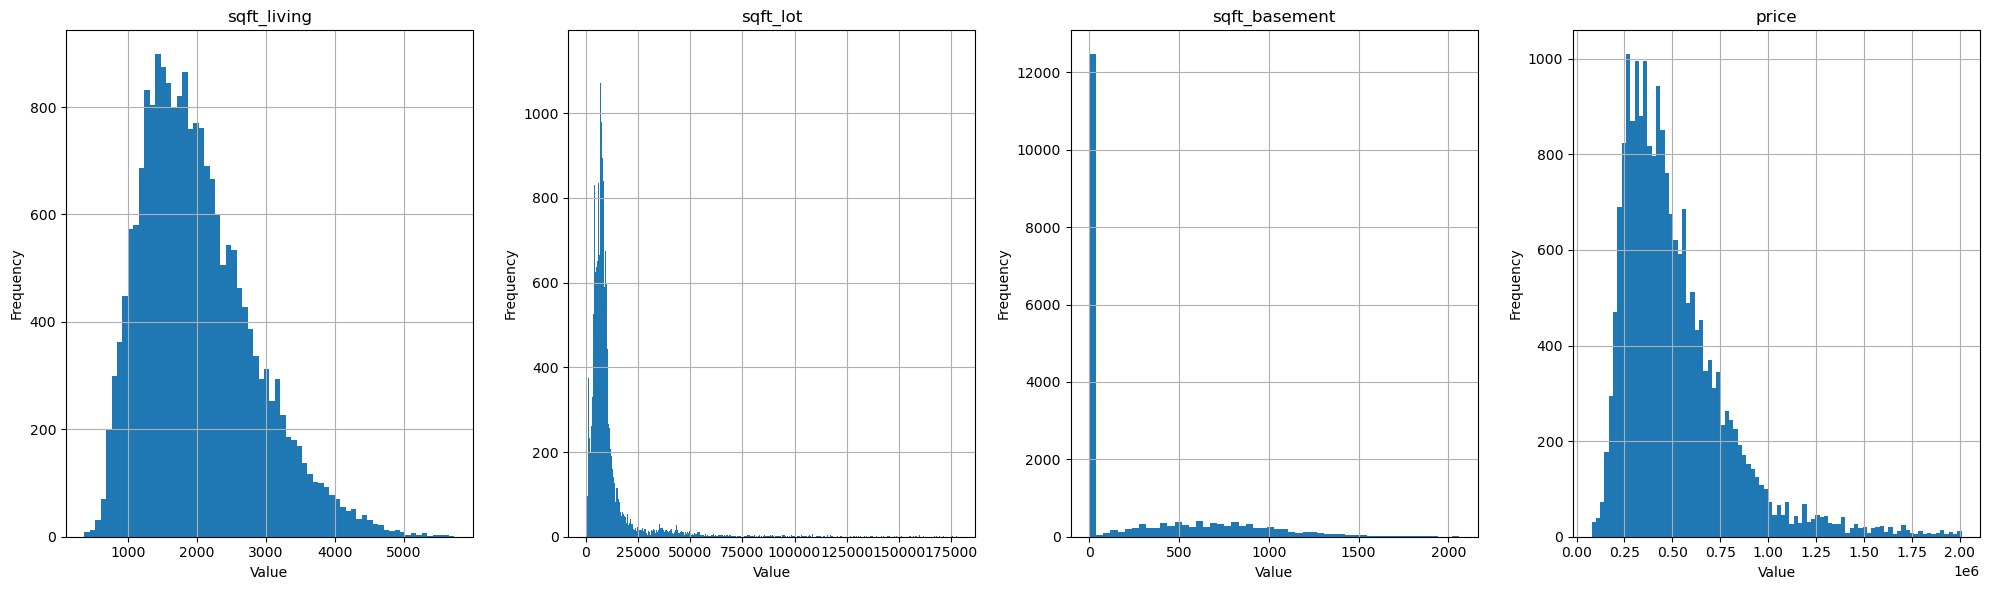

In [58]:
# Plot histograms for each variable
fig, axes = plt.subplots(1, 4, figsize=(20, 6))

for i, col in enumerate(continuous_var_2):
    df_edition_7[col].hist(ax=axes[i], bins='auto')
    axes[i].set_title(f'{col}')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [73]:
#Log transform the continuous variables
log_names = [f'{column}_log' for column in df_edition_7[continuous_var_2].columns]
continuous_logged = np.log1p(df_edition_7[continuous_var_2])
continuous_logged.columns = log_names

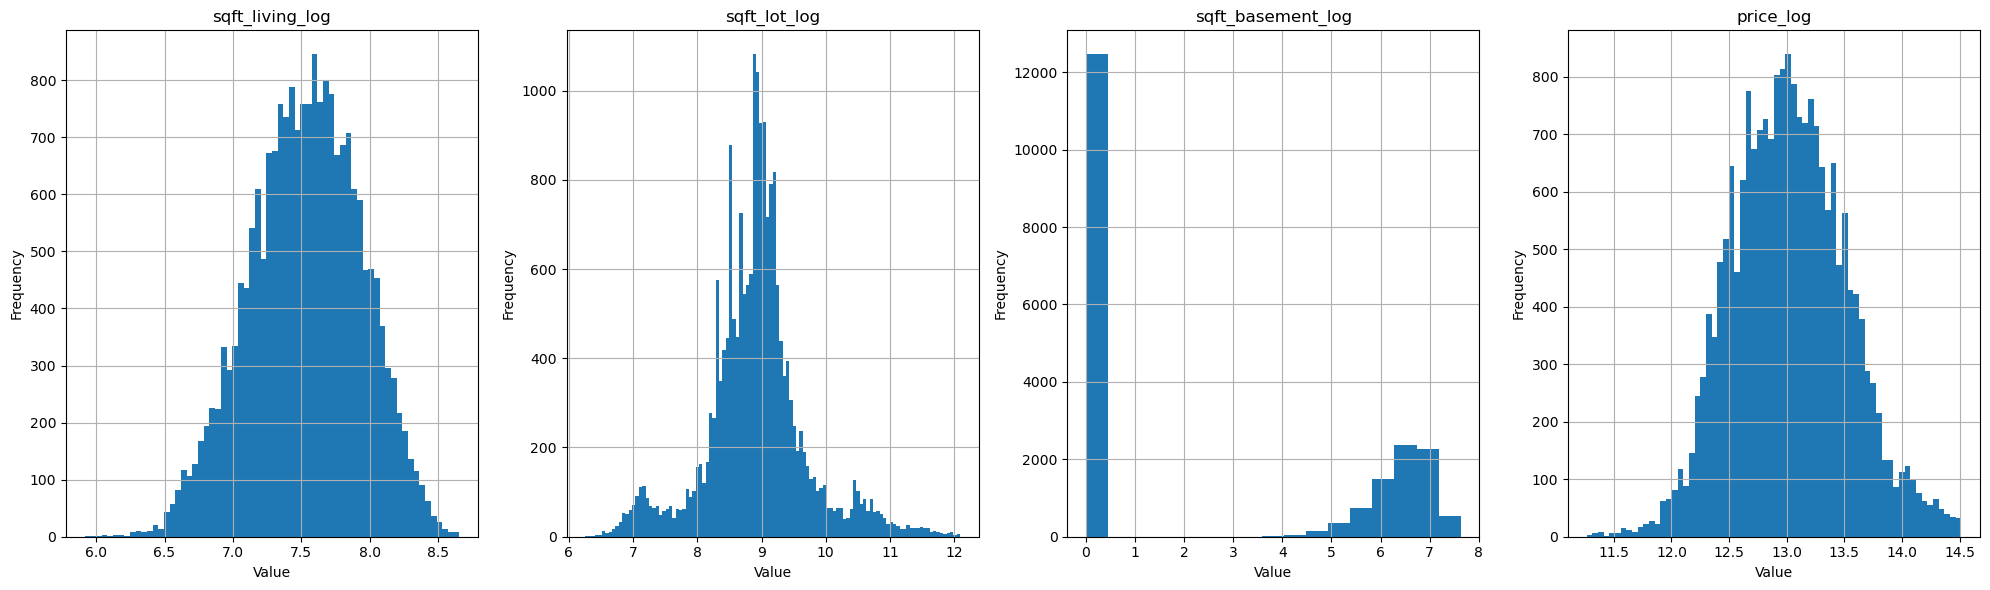

In [74]:
fig, axes = plt.subplots(nrows=1, ncols=len(continuous_logged.columns), figsize=(20, 6))
for i, col in enumerate(continuous_logged.columns):
    continuous_logged[col].hist(ax=axes[i], bins='auto')
    axes[i].set_title(f'{col}')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [75]:
#normalize
def normalize(feature):
    return (feature - feature.mean()) / feature.std()

cont_transformed = continuous_logged.apply(normalize)

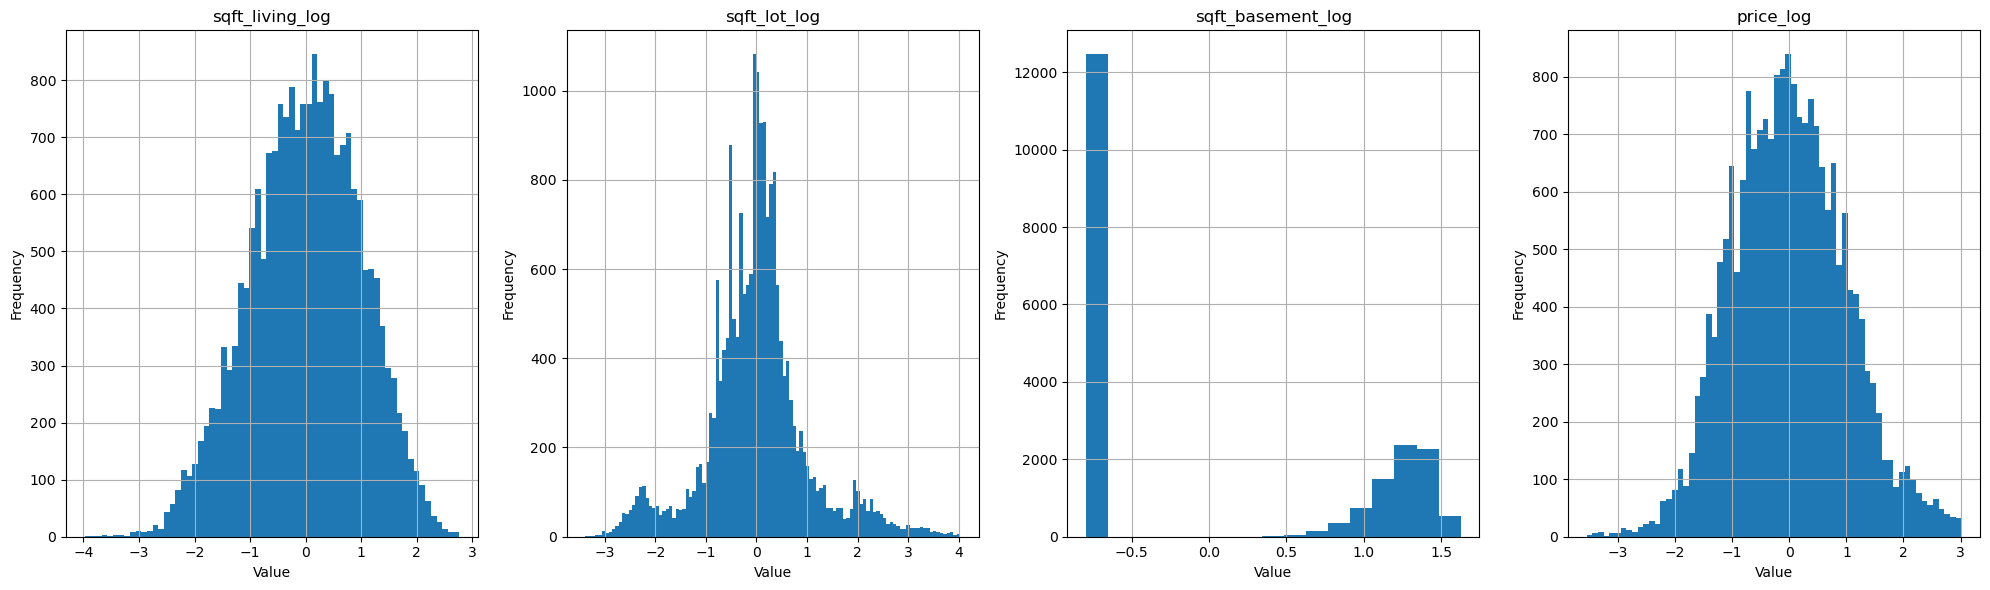

In [76]:
#Check normalization with histogram
fig, axes = plt.subplots(nrows=1, ncols=len(cont_transformed.columns), figsize=(20, 6))
for i, col in enumerate(cont_transformed.columns):
    cont_transformed[col].hist(ax=axes[i], bins='auto')
    axes[i].set_title(f'{col}')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [77]:
#Merge normalised columns back to the data frame and drop the original columns of each
df_edition_8 = pd.concat([df_edition_7.drop(continuous_var_2, axis=1),cont_transformed])

#Rename the log transformed column 'price_log' back to 'price'
df_edition_8.rename(columns={'price_log': 'price'}, inplace=True)

In [80]:
print(np.isnan(X).sum())
print(np.isinf(X).sum())

const                    0
beds_2               20444
beds_3               20444
beds_4               20444
beds_5               20444
                     ...  
zip_98198            20444
zip_98199            20444
sqft_living_log      20444
sqft_lot_log         20444
sqft_basement_log    20444
Length: 115, dtype: int64
const                0
beds_2               0
beds_3               0
beds_4               0
beds_5               0
                    ..
zip_98198            0
zip_98199            0
sqft_living_log      0
sqft_lot_log         0
sqft_basement_log    0
Length: 115, dtype: int64


In [81]:
#Create a new variable for all the predictor columns
predictor_cols_2 = df_edition_8.drop(['price'], axis=1)

#Fit the model - First iteration
outcome = 'price'
x_cols = predictor_cols_2.columns
X = df_edition_8[x_cols]
X = add_constant(X)
Y = df_edition_8[outcome]
model = OLS(Y, X).fit()
model.summary()

MissingDataError: exog contains inf or nans